<a href="https://colab.research.google.com/github/JuanZapa7a/Medical-Image-Processing/blob/main/Using_Pytorch_to_fight_cancer_(II).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Augmentation

### Setting our work environment

In [1]:
!nvidia-smi

Thu May 16 14:17:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Setting our $HOME to /content
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
##  Loading a Dataset

# Create the dataset directory
import os
datasets_dir = os.path.join(HOME, "datasets")
os.makedirs(datasets_dir, exist_ok=True)
print(os.getcwd())

/content


In [5]:
# Change to new datsets folder and download the dataset
os.chdir(datasets_dir)
print('dataset_dir =', os.getcwd())
if  not os.path.isfile('exp0.zip'):
  !wget -q https://www.dropbox.com/s/7ir1jixrs1aw55n/exp0.zip
!unzip -qq -o exp0.zip

dataset_dir = /content/datasets


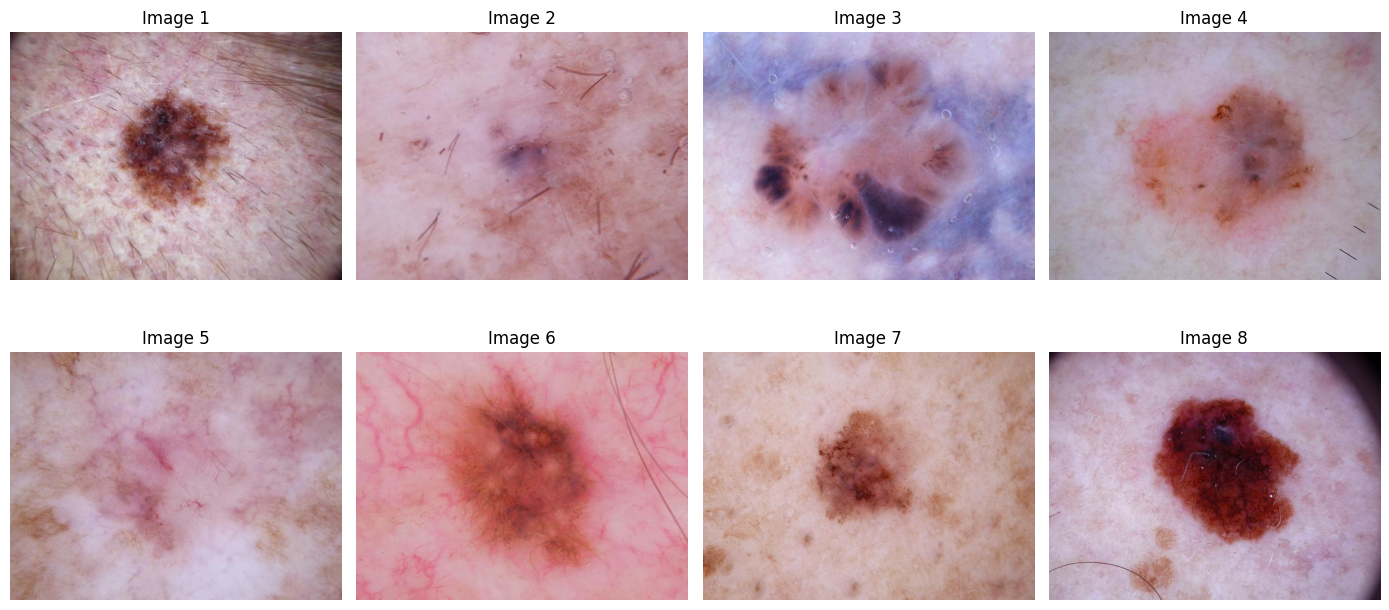

In [6]:
# creates a figure with subplots arranged in a 2x4 grid
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg

# Directory of the images
image_directory = f'/content/datasets/exp0/test/class_1/'

# List of image paths
image_paths = glob.glob(image_directory + '*.jpg')[:8]

# Set up the figure with subplots
fig, axs = plt.subplots(2, 4, figsize=(14, 7))

# Iterate through the images and display them in the subplots
for i, image_path in enumerate(image_paths):
    row = i // 4
    col = i % 4
    img = mpimg.imread(image_path)
    axs[row, col].imshow(img)
    axs[row, col].set_title(f'Image {i + 1}')
    axs[row, col].axis('off')

# Adjust the layout of the subplots
plt.tight_layout()
plt.show()
print("\n Size of image: ", img.shape)

In [7]:
import torch
import torchvision
from torch.utils.data import DataLoader, ConcatDataset # CancatDataset is new
from torchvision import datasets
import torchvision.transforms as transforms
from tqdm import tqdm # progress bar


 Size of image:  (450, 600, 3)


In [8]:
%%time

# 1. Calculate the mean and standard deviation on the training set.
# train, validation and test data directory

train_dir = "/content/datasets/exp0/train/"
val_dir  = "/content/datasets/exp0/test/"
test_dir   = "/content/datasets/exp0/val/"

# transform to calculate mean and standard desviation
transform = transforms.Compose([
    transforms.ToTensor()  # transform images to tensor
])

# Load the ImageFolder dataset and apply the transformation
dataset = datasets.ImageFolder(root= train_dir, transform=transform)

# it's better to use a loader to retrieve images (tensors)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Initialize variables to store the sum of pixel values and
# standard deviation.
# These variables are set to floating-point zeros to ensure
# accurate calculations.
mean_sum = 0.0
std_sum = 0.0
total_samples = 0

# Iterates over the data loader (loader),
# calculates the mean and standard deviation across all channels
# for each batch(0) and spatial dimensions (height(2) and width(3))
for images, _ in loader:
    mean_sum += torch.mean(images, dim=[0, 2, 3])
    std_sum += torch.std(images, dim=[0, 2, 3])
    total_samples += 1

mean = mean_sum / total_samples
std = std_sum / total_samples

print("Total train samples:", total_samples)
print("Mean:", mean)
print("Std:", std)

Total train samples: 2700
Mean: tensor([0.7513, 0.5535, 0.5788])
Std: tensor([0.0921, 0.1196, 0.1349])
CPU times: user 28.6 s, sys: 675 ms, total: 29.3 s
Wall time: 29.6 s


In [9]:
# Define the data transformations to be applied
# to each transformed dataset
transformations = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomPerspective(),
    #transforms.RandomErasing(p=0.5, scale=(1.0, 1.0), ratio=(1.0, 1.0),value='random'),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.2), ratio=(0.75, 1.33333333)),
]

# Add the ToTensor() and Normalize() transformation
# to each data transformation
for i in range(len(transformations)):
    transformations[i] = transforms.Compose([
        transformations[i],
        #transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

print(transformations)

[Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    RandomCrop(size=(64, 64), padding=4)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=None)
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    RandomAffine(degrees=[-30.0, 30.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
    ToTensor()
    Normalize(mean=tensor([0.7513, 0.5535, 0.5788]), std=tensor([0.0921, 0.1196, 0.1349]))
), Compose(
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    ToTensor

In [10]:
%time

# 2. Normalize the training set using these statistics.
train_data = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

# 3. Normalize the test and validation set using the same statistics
# calculated on the training set.
val_set = datasets.ImageFolder(val_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

test_set = datasets.ImageFolder(test_dir,transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)

print(f"Length of Train Data :{len(train_data)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")

classes = train_data.classes
print('Classes: ', classes)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs
Length of Train Data :2700
Length of Validation Data : 600
Length of Test Data : 300
Classes:  ['class_0', 'class_1']


In [11]:
# Aplicar cada transformación separada a un conjunto de datos transformado y concatenarlos
train_set = train_data
for transform in transformations:
    transformed_data = datasets.ImageFolder(train_dir,transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
)
    train_set = ConcatDataset([train_set, transformed_data])

print(f"Length of Train Data :{len(train_set)}")
print(f"Length of Validation Data : {len(val_set)}")
print(f"Length of Test Data : {len(test_set)}")


Length of Train Data :24300
Length of Validation Data : 600
Length of Test Data : 300


CPU times: user 4.77 s, sys: 65.3 ms, total: 4.84 s
Wall time: 4.93 s


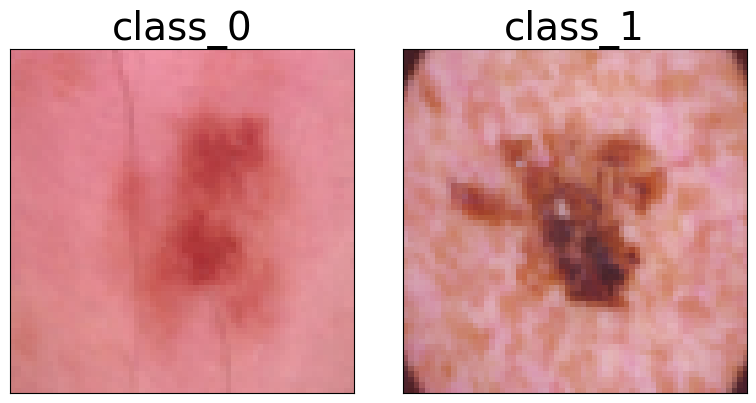

In [12]:
%%time
inv_normalize = transforms.Normalize(
  mean= [-m/s for m, s in zip(mean, std)],
  std= [1/s for s in std]
)

fig, ax = plt.subplots(nrows=1, ncols=len(classes), figsize=(2*4,1*4),
                       subplot_kw={'facecolor': "#ebf5ff"})

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[i], fontsize=28)
  img = next(img for img,label in train_set if label == i)
  #ax.imshow(img.permute(1,2,0)) # for normalized channels
  ax.imshow(inv_normalize(img).permute(1,2,0)) # for unnormalized

fig.tight_layout()


In [26]:
# batch size defines how many training or testing samples
# to use in a single iteration
batch_size = 32
# epochs define the number of iterations
epochs = 20
# num_classes define the number of the class
num_classes = len(classes)
print(f"Number of Classes: {num_classes}")

Number of Classes: 2


In [14]:
%%time

# Create dataloaders object for training/val loop.

train_dataloader = DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=True,
  num_workers=2)

val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)

CPU times: user 166 µs, sys: 8 µs, total: 174 µs
Wall time: 180 µs


In [15]:
# We define a small function to determine the columns and rows needed
# for a given number of images.
def rows_cols(input):

    divisors = []

    # Realize a little operation with input
    # in order to determine divisors for input
    for i in range(1, input+1): # not divide by 0
        if input % i == 0:
            divisors.append(i)

    # divisors list size
    n = len(divisors)

    # If the size is odd, the element in the middle is the median value.
    if n % 2 != 0:
        median_index = (n - 1) // 2
        rows = divisors[median_index]
    # If the size is even, the two elements in the middle are equal
    else:
        median_index1 = n // 2 - 1
        rows = divisors[median_index1]

    cols = int(input/rows)
    return rows, cols


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


CPU times: user 1.71 s, sys: 640 ms, total: 2.35 s
Wall time: 51 s


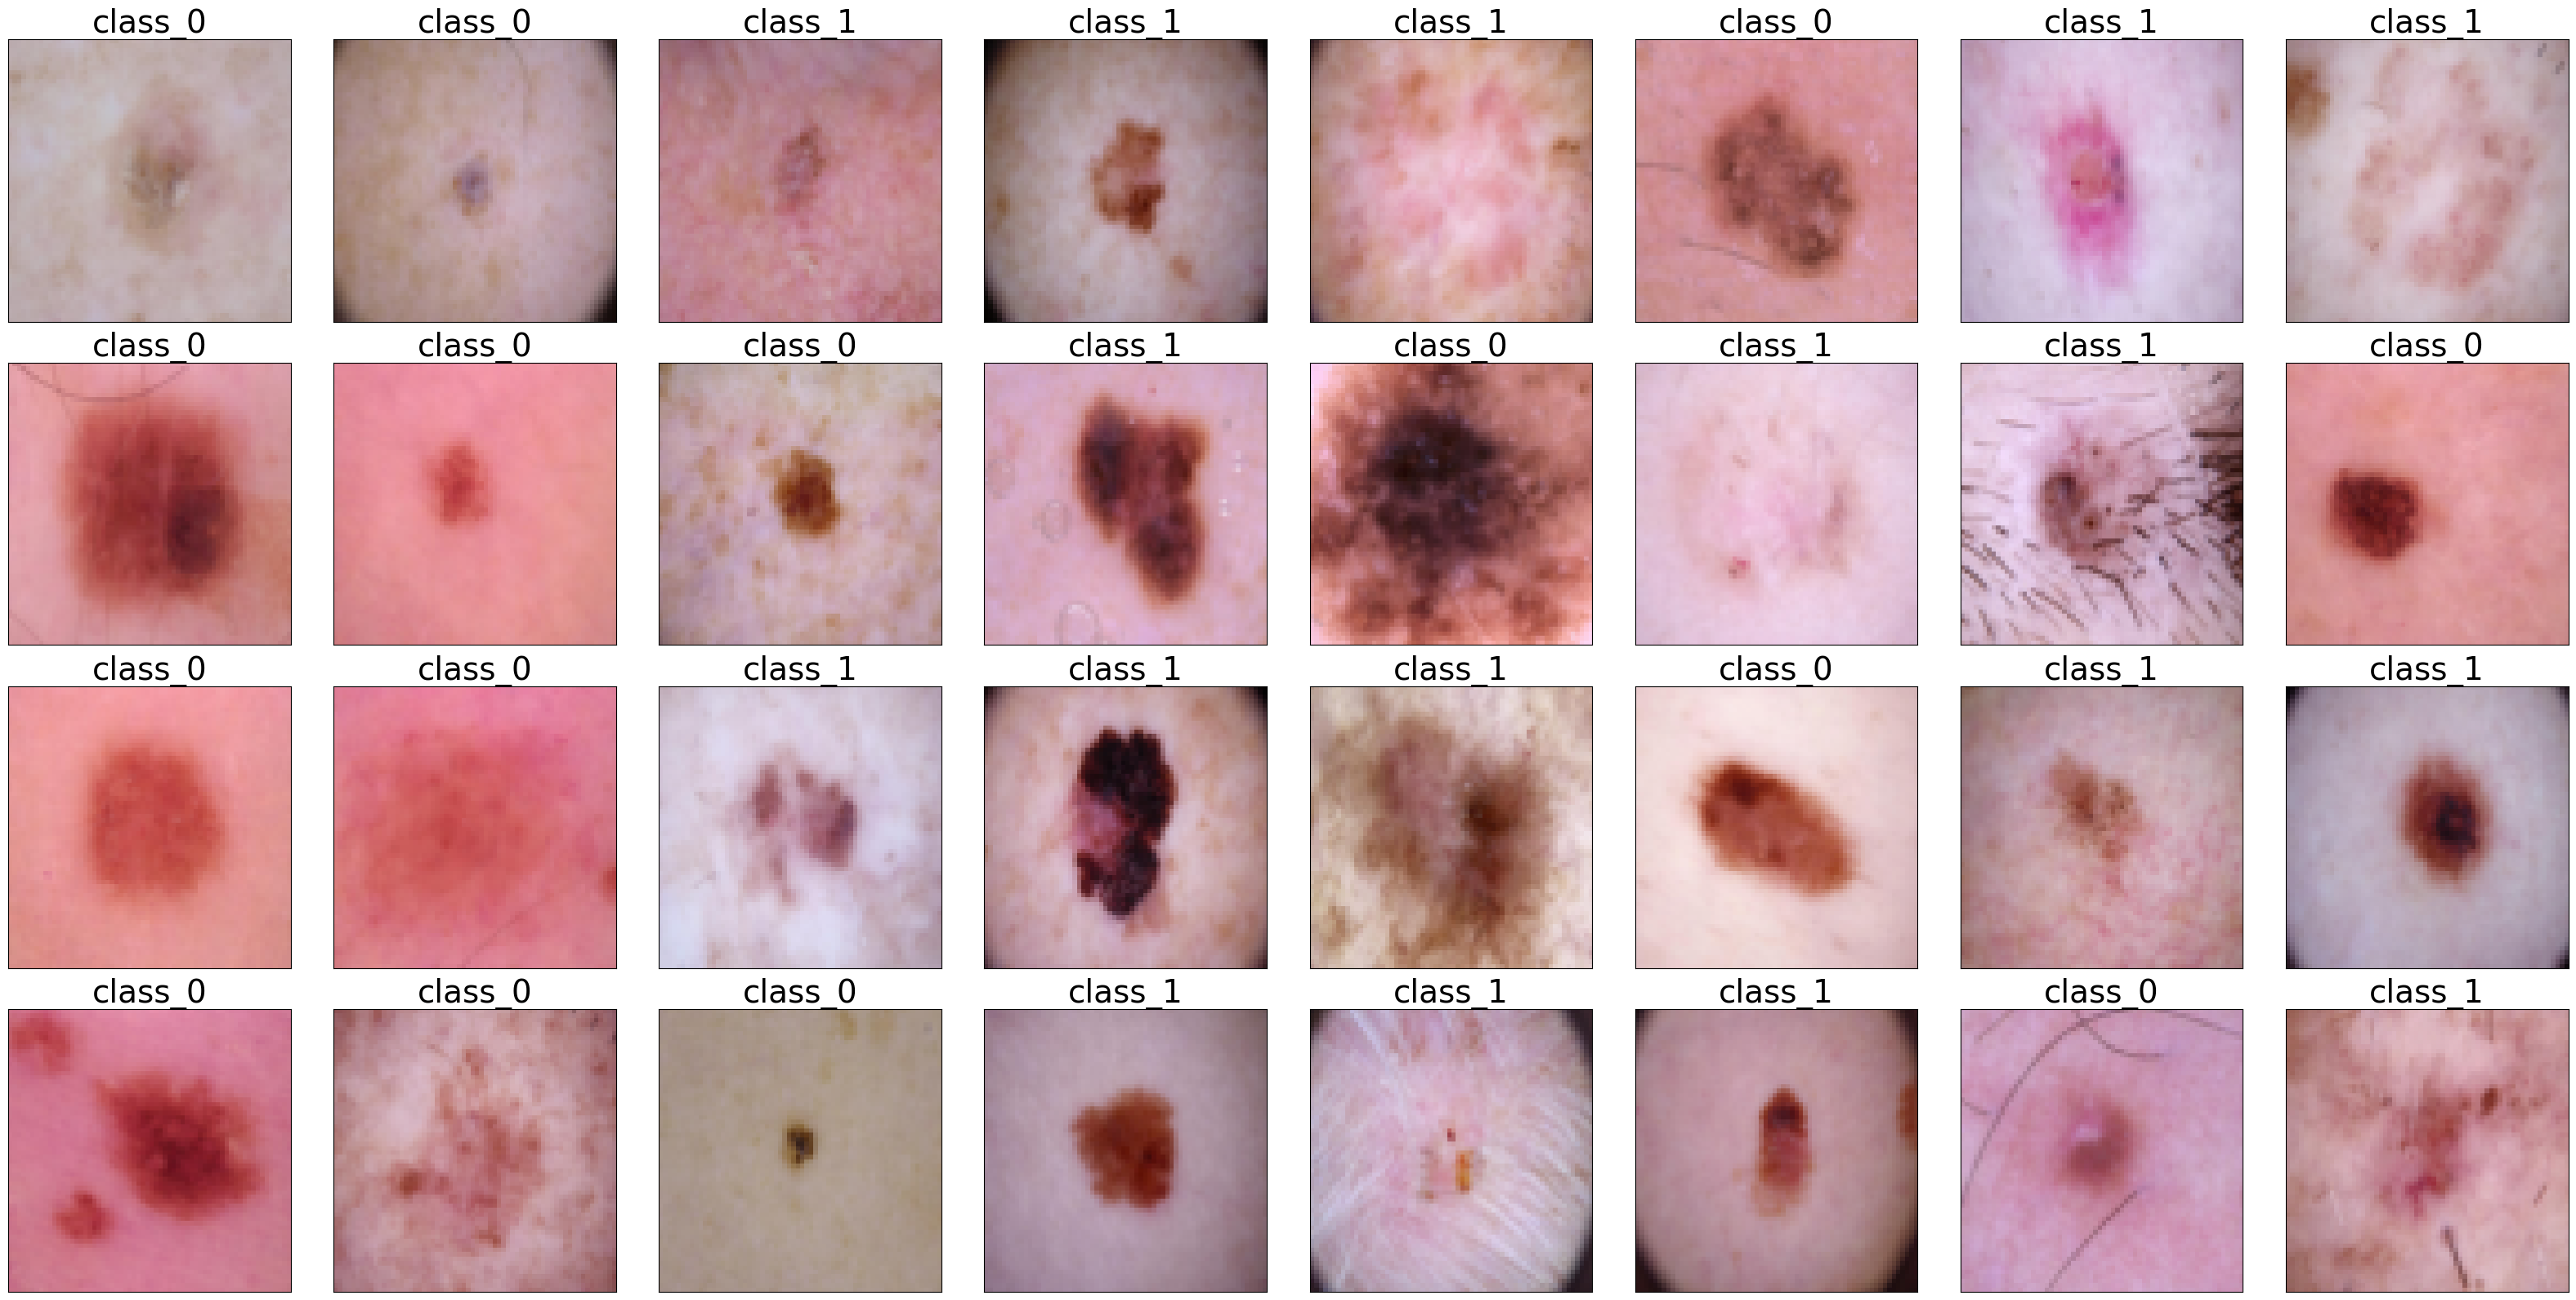

In [16]:
%%time

import itertools
import numpy as np
import os

nrows,ncols = rows_cols(batch_size)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),
                       subplot_kw={'facecolor': "#ebf5ff"})
rb_index = np.random.randint(0, len(train_dataloader))

# Obtener el batch correspondiente al índice aleatorio
imgs, labels = next(itertools.islice(train_dataloader, rb_index, rb_index+1))

for i, ax in enumerate(ax.flatten()):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(classes[labels[i]], fontsize=28)
  #ax.imshow(imgs[i].permute(1,2,0)) # for unnormalized
  ax.imshow(inv_normalize(imgs[i]).permute(1,2,0)) # for unnormalized

fig.tight_layout()

In [17]:
import torch.nn as nn
import torch.nn.functional as F

In [18]:
# Large Model
class myCNN(nn.Module):
    def __init__(self): # defines the constructor method __init__()
                        # for the myCNN class. This method is called
                        # when an instance of the class is created.
        super().__init__() # calls the constructor of the parent class
                           # (nn.Module) using Python's super() function.
                           # It initializes the parent class, allowing the
                           # myCNN class to inherit functionality from nn.Module.

        self.network = nn.Sequential(

            # Layer 1: Conv2d
            # Input: (batch_size, 3, 64, 64)
            # Output: (batch_size, 32, 64, 64)
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Layer 2: Conv2d
            # Input: (batch_size, 32, 64, 64)
            # Output: (batch_size, 64, 64, 64)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 3: MaxPool2d
            # Input: (batch_size, 64, 64, 64)
            # Output: (batch_size, 64, 32, 32)
            nn.MaxPool2d(2, 2),

            # Layer 4: Conv2d
            # Input: (batch_size, 64, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 5: Conv2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 32, 32)
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 6: MaxPool2d
            # Input: (batch_size, 128, 32, 32)
            # Output: (batch_size, 128, 16, 16)
            nn.MaxPool2d(2, 2),

            # Layer 7: Conv2d
            # Input: (batch_size, 128, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 8: Conv2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 16, 16)
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Layer 9: MaxPool2d
            # Input: (batch_size, 256, 16, 16)
            # Output: (batch_size, 256, 8, 8)
            nn.MaxPool2d(2, 2),

            # Layer 10: Flatten
            # Input: (batch_size, 256, 8, 8)
            # Output: (batch_size, 16384)
            nn.Flatten(),

            # Layer 11: Linear
            # Input: (batch_size, 16384)
            # Output: (batch_size, 128)
            nn.Linear(16384, 128),
            nn.ReLU(),

            # Layer 12: Linear
            # Input: (batch_size, 128)
            # Output: (batch_size, 64)
            nn.Linear(128, 64),
            nn.ReLU(),

            # Layer 13: Linear
            # Input: (batch_size, 64)
            # Output: (batch_size, 2)
            nn.Linear(64, 2)
        )
    # The forward method takes a single argument xb,
    # which represents the input data to the neural network.
    # Inside the forward method, the input xb is passed through the
    # neural network layers defined in self.network. The result of this
    # computation is then returned as the output of the forward method.
    def forward(self, xb):
        return self.network(xb)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


model = myCNN().to(device)
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
  model = nn.DataParallel(model)

print(model)

Using cuda device
myCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=16384, out_features=128, bias=True)
    (17): ReLU()
    (18): Linear

In [20]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()
# Define your optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.001,
                            momentum=0.9,
                            weight_decay=0.001 )
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
print (f"Train dataset size={len(train_dataloader.dataset)}") #number of images from dataset
print (f"Number of batches={len(train_dataloader)}") # number of images/batch_size (or number of batches)

Train dataset size=24300
Number of batches=760


In [22]:
def train(dataloader, model, criterion, optimizer):
  running_loss, corrects, current = 0, 0, 0
  size = len(dataloader.dataset) # number images from dataset
  print(f"Training:")
  model.train() #training mode on
  loop = tqdm(train_dataloader) # Initialize a progress bar
  for batch, (X, y) in enumerate(loop):
    # take data (X) and label (y) from a batch
    X, y = X.to(device), y.to(device) # Move the data and labels
                                      # to the device (CPU or GPU)

    # forward pass
    preds = model(X) # Compute predictions
    loss = criterion(preds, y) # Compute the loss between predictions and labels

    # backpropagation
    optimizer.zero_grad()   # zero the gradient buffers
    loss.backward()         # compute gradients to backwards
    optimizer.step()        # Does the "update weights" of model

    # Calculate Output Metrics training_loss, training_accuracy

    # 1. loss.item() contains the loss of entire mini-batch converted to scalar
    running_loss += loss.item() # Accumulate the loss for this batch

    # 2. current image (last image in the batch) for progressive bar
    current += len(X) # Update the current number of processed images

    # 3. From the predictions, I select the index (class) of the one with
    # the highest value and compare it with the label (class). The boolean value
    # is converted into a float (true becomes 1, false becomes 0), and all are
    # summed up. Finally, 'item' converts them into a scalar value.
    # This way, 'corrects' reflects the number of correct predictions (accuracy)
    corrects += (preds.argmax(1) == y).type(torch.float).sum().item()

    # 4. running loss is the sum of our loss. Training loss is a running average
    # through batches
    training_loss = running_loss/(batch+1)

    # 5. Training accuracy = number of corrects predictions/number of processed images
    training_accuracy = corrects/current

    # Update the progress bar with current epoch, batch, and metrics
    loop.set_description(f'[{epoch + 1}/{epochs} epochs, {current:>5d}/{len(train_dataloader.dataset):>5d} data]')
    loop.set_postfix(Training_Loss=training_loss, Accuracy=f'{100*corrects/current:>0.1f}%')

  return training_loss, training_accuracy

In [23]:
def val(dataloader, model, criterion):
  size = len(dataloader.dataset) # number images from dataset to evaluate
  num_batches = len(dataloader)  # number of batches

  # Evaluation (test)) Mode
  model.eval()

  val_loss, corrects = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      # prediction for a dataset not used in training
      # compute prediction error and number of corrects
      # through batches
      preds = model(X)
      val_loss += criterion(preds, y).item()
      corrects += (preds.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  corrects /= size
  print(f"Test: \n Accuracy: {(100*corrects):>0.1f}%, val_Loss: {val_loss:>8f} \n")

  return val_loss, corrects

In [27]:
%%time

import csv

loss_train_history = []
accuracy_train_history = []
loss_val_history = []
accuracy_val_history = []

for epoch in range(epochs): # Iterates over each epoch and performs training and evaluation.
  # Train the model on the training data and saves
  #the training loss and accuracy for the current epoch
  loss_train,acc_train = train(train_dataloader, model, criterion, optimizer)
  loss_train_history.append(loss_train)
  accuracy_train_history.append(acc_train)

  # Evaluate the model on the test data and saves
  # the test loss and accuracy for the current epoch.
  loss_test,acc_test= val(val_dataloader, model, criterion)
  loss_val_history.append(loss_test)
  accuracy_val_history.append(acc_test)

print("Done!. Finished Training")

# Saves the training and test loss, as well as the training and test accuracy,
# for each epoch to a CSV file named "metrics_myCNN.csv".
print("Saving model and metrics!.")
# Save the metrics to a CSV file.
with open('metrics_myCNN.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Val Loss', 'Val Accuracy'])
    for epoch, (train_loss, train_accuracy, val_loss, val_accuracy) in enumerate(zip(loss_train_history, accuracy_train_history, loss_val_history, accuracy_val_history)):
        writer.writerow([epoch+1, train_loss, train_accuracy, val_loss, val_accuracy])

# Saves the trained model's state dictionary to a file named "myCNN.pth".
#torch.save(model.state_dict(), "myCNN.pth")

torch.save({
    'optimizer': optimizer.state_dict(),
    'model': model.state_dict(),
}, "myCNN.pth")

print("Model and metrics saved!.")

Training:


[1/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:18<00:00,  9.65it/s, Accuracy=84.3%, Training_Loss=0.334]


Test: 
 Accuracy: 77.8%, val_Loss: 0.551960 

Training:


[2/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:20<00:00,  9.39it/s, Accuracy=87.5%, Training_Loss=0.278]


Test: 
 Accuracy: 74.0%, val_Loss: 0.584324 

Training:


[3/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:17<00:00,  9.84it/s, Accuracy=90.8%, Training_Loss=0.217]


Test: 
 Accuracy: 78.0%, val_Loss: 0.727062 

Training:


[4/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:19<00:00,  9.61it/s, Accuracy=93.5%, Training_Loss=0.162]


Test: 
 Accuracy: 75.7%, val_Loss: 0.772490 

Training:


[5/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:20<00:00,  9.38it/s, Accuracy=95.6%, Training_Loss=0.116]


Test: 
 Accuracy: 77.7%, val_Loss: 0.925248 

Training:


[6/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:18<00:00,  9.67it/s, Accuracy=97.3%, Training_Loss=0.073]


Test: 
 Accuracy: 78.3%, val_Loss: 1.081833 

Training:


[7/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:20<00:00,  9.47it/s, Accuracy=98.4%, Training_Loss=0.0478]


Test: 
 Accuracy: 75.5%, val_Loss: 1.377762 

Training:


[8/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:19<00:00,  9.61it/s, Accuracy=99.4%, Training_Loss=0.0184]


Test: 
 Accuracy: 75.8%, val_Loss: 1.650416 

Training:


[9/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:20<00:00,  9.43it/s, Accuracy=100.0%, Training_Loss=0.000794]


Test: 
 Accuracy: 76.3%, val_Loss: 1.854045 

Training:


[10/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:20<00:00,  9.39it/s, Accuracy=100.0%, Training_Loss=0.000433]


Test: 
 Accuracy: 76.3%, val_Loss: 1.915648 

Training:


[11/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:18<00:00,  9.71it/s, Accuracy=100.0%, Training_Loss=0.00036]


Test: 
 Accuracy: 76.5%, val_Loss: 1.941744 

Training:


[12/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:20<00:00,  9.41it/s, Accuracy=100.0%, Training_Loss=0.000331]


Test: 
 Accuracy: 76.0%, val_Loss: 1.947006 

Training:


[13/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:19<00:00,  9.55it/s, Accuracy=100.0%, Training_Loss=0.000318]


Test: 
 Accuracy: 76.0%, val_Loss: 1.933449 

Training:


[14/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:21<00:00,  9.37it/s, Accuracy=100.0%, Training_Loss=0.00031]


Test: 
 Accuracy: 76.3%, val_Loss: 1.932178 

Training:


[15/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:28<00:00,  8.61it/s, Accuracy=100.0%, Training_Loss=0.000311]


Test: 
 Accuracy: 76.3%, val_Loss: 1.922551 

Training:


[16/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:20<00:00,  9.49it/s, Accuracy=100.0%, Training_Loss=0.000309]


Test: 
 Accuracy: 76.0%, val_Loss: 1.908101 

Training:


[17/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:18<00:00,  9.65it/s, Accuracy=100.0%, Training_Loss=0.000316]


Test: 
 Accuracy: 76.3%, val_Loss: 1.898183 

Training:


[18/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:21<00:00,  9.30it/s, Accuracy=100.0%, Training_Loss=0.00032]


Test: 
 Accuracy: 76.3%, val_Loss: 1.889110 

Training:


[19/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:19<00:00,  9.53it/s, Accuracy=100.0%, Training_Loss=0.000327]


Test: 
 Accuracy: 76.5%, val_Loss: 1.876661 

Training:


[20/20 epochs, 24300/24300 data]: 100%|██████████| 760/760 [01:19<00:00,  9.57it/s, Accuracy=100.0%, Training_Loss=0.000326]


Test: 
 Accuracy: 76.8%, val_Loss: 1.869448 

Done!. Finished Training
Saving model and metrics!.
Model and metrics saved!.
CPU times: user 6min 18s, sys: 24.6 s, total: 6min 42s
Wall time: 27min 21s


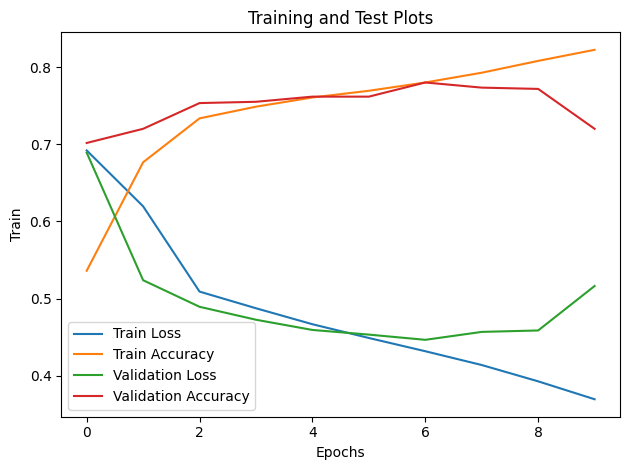

In [25]:
fig, ax = plt.subplots()

ax.set_title('Training and Test Plots')
ax.plot(range(epochs), loss_train_history, label="Train Loss")
ax.plot(range(epochs), accuracy_train_history, label="Train Accuracy")
ax.plot(range(epochs), loss_val_history, label="Validation Loss")
ax.plot(range(epochs), accuracy_val_history, label="Validation Accuracy")
ax.set_xlabel("Epochs")
ax.set_ylabel("Train")
ax.legend()

fig.tight_layout()

In [28]:
# Supongamos que tienes tu modelo entrenado y los conjuntos de datos divididos
val_dataloader = DataLoader(
  val_set,
  batch_size=batch_size,
  shuffle=False,
  num_workers=2)


import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

# Define una función para obtener las predicciones del modelo
def obtener_predicciones(modelo, dataloader):
    preds = []
    etiquetas = []
    for batch in dataloader:
        inputs, etiquetas_batch = batch
        inputs = inputs.to(device)  # Si estás utilizando GPU, mueve los datos a la GPU
        outputs = modelo(inputs)
        _, predicciones = torch.max(outputs, 1)
        preds.extend(predicciones.tolist())
        etiquetas.extend(etiquetas_batch.tolist())
    return preds, etiquetas

# Define el dispositivo (CPU o GPU) en el que se realizarán las operaciones
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo guardado
model_file = "myCNN.pth"
checkpoint = torch.load(model_file, map_location=device)
model_state_dict = checkpoint['model']

# Supongamos que 'val_dataloader' es tu DataLoader de validación

# Definir y cargar el modelo
# Asegúrate de definir tu modelo adecuadamente
model = myCNN()
model.load_state_dict(model_state_dict)
model.to(device)
model.eval()

# Obtén las predicciones del modelo y las etiquetas verdaderas del conjunto de validación
predicciones_val, etiquetas_val = obtener_predicciones(model, val_dataloader)

# Calcular la matriz de confusión
cm = confusion_matrix(etiquetas_val, predicciones_val)

# Extraer los valores de la matriz de confusión
tn, fp, fn, tp = cm.ravel()

# Imprimir los valores
print("Verdaderos negativos (TN):", tn)
print("Falsos positivos (FP):", fp)
print("Falsos negativos (FN):", fn)
print("Verdaderos positivos (TP):", tp)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Verdaderos negativos (TN): 233
Falsos positivos (FP): 67
Falsos negativos (FN): 72
Verdaderos positivos (TP): 228


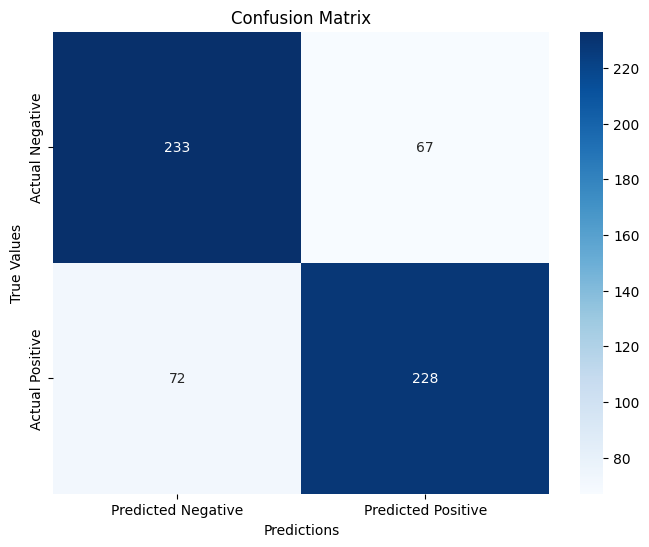

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming 'etiquetas_val' are the true labels and 'predicciones_val' are the model predictions

# Calculate the confusion matrix
cm = confusion_matrix(etiquetas_val, predicciones_val)

# Create a Pandas DataFrame for the confusion matrix
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.show()

In [30]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(etiquetas_val, predicciones_val)

# Print the report
print(report)


              precision    recall  f1-score   support

           0       0.76      0.78      0.77       300
           1       0.77      0.76      0.77       300

    accuracy                           0.77       600
   macro avg       0.77      0.77      0.77       600
weighted avg       0.77      0.77      0.77       600

